In [1]:
import numpy as np
import edt
import copy
from medpy.io import load as medpyload
from sklearn.cluster import DBSCAN
from scipy import ndimage
import matplotlib.pyplot as plt
from func.dataset_preprocess import process_one_cuboid, dbscan, distance_trans

In [19]:
def process_one_cuboid_new(input_3d_image, width_of_membrane=1.5, need_cell_center_info = False):
    input_3d_image=np.array(input_3d_image)
    # background 3D mask
    #--------------------------------------------------
    background_3d_mask=np.zeros(input_3d_image.shape)
    background_3d_mask[input_3d_image==0]=1
    #--------------------------------------------------

    # boundary, foreground, and cell_instance mask
    #--------------------------------------------------
    input_3d_image_shape=input_3d_image.shape
    boundary_3d_mask=np.zeros(input_3d_image_shape)
    edge_boundary_3d_mask=np.zeros(input_3d_image_shape)
    edge_foreground_3d_mask=np.zeros(input_3d_image_shape)
    edge_background_3d_mask=np.zeros(input_3d_image_shape)
    foreground_3d_mask=np.zeros(input_3d_image_shape)
    cell_ins_3d_mask=np.zeros(input_3d_image_shape)

    # center dict
    center_dict = dict()

    mask_unique_values, mask_unique_counts=np.unique(input_3d_image, return_counts=True)
    mask_unique_values=np.array(mask_unique_values)
    mask_unique_counts=np.array(mask_unique_counts)

    # 0 means background, no mask
    mask_unique_counts=mask_unique_counts[mask_unique_values>0]
    mask_unique_values=mask_unique_values[mask_unique_values>0]

    for i in mask_unique_values:
        locs=np.where(input_3d_image==i)
        x_max=np.max(locs[0])
        y_max=np.max(locs[1])
        z_max=np.max(locs[2])
        x_min=np.min(locs[0])
        y_min=np.min(locs[1])
        z_min=np.min(locs[2])

        print('progress: '+str(i/len(mask_unique_values)), end='\r')

        temp_3d_img=copy.deepcopy(input_3d_image[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1])
        temp_3d_img[np.where(temp_3d_img!=i)]=0
        temp_3d_img_dt = distance_trans(temp_3d_img)

        k=width_of_membrane

        # boundary
        temp_boundary_3d_mask=copy.deepcopy(boundary_3d_mask[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1])
        temp_boundary_3d_mask[np.where(np.logical_and(temp_3d_img_dt>=1, temp_3d_img_dt<=k))]=1
        #temp_boundary_3d_mask[np.where(temp_3d_img_dt==1)]=1
        boundary_3d_mask[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]=temp_boundary_3d_mask

        # foreground
        temp_foreground_3d_mask=copy.deepcopy(foreground_3d_mask[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1])
        temp_foreground_3d_mask[np.where(temp_3d_img_dt>k)]=1 #temp_3d_img_dt[np.where(temp_3d_img_dt>k)]
        foreground_3d_mask[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]=temp_foreground_3d_mask

        # cell instances
        seg_single_cells, clustering_labels_unique, clustering_labels_counts = \
        dbscan(temp_3d_img_dt)
        seg_single_cells[seg_single_cells>0] = seg_single_cells[seg_single_cells>0] + i*3
        clustering_labels_unique = clustering_labels_unique + i*3
        cell_ins_3d_mask[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]+=seg_single_cells

        if need_cell_center_info:
            # centers
            for i in range(0, len(clustering_labels_unique)):
                temp_label = clustering_labels_unique[i]
                temp_f_3d_mask = np.zeros(foreground_3d_mask.shape)
                temp_f_3d_mask[np.where(cell_ins_3d_mask==temp_label)] = foreground_3d_mask[np.where(cell_ins_3d_mask==temp_label)]
                radius = np.max(temp_f_3d_mask)
                center_loc = np.where(temp_f_3d_mask==radius)
                del temp_f_3d_mask
                center_loc = (center_loc[0][0], center_loc[1][0], center_loc[2][0])
                center_dict[temp_label] = {"radius": radius, "center_loc": center_loc}

    seg_img_fg=np.zeros(foreground_3d_mask.shape)
    seg_img_fg[np.where(foreground_3d_mask>0)]=1
    seg_img_fg=np.array(seg_img_fg, dtype=np.uint32, order='F')
    seg_img_fg_dt=edt.edt(
        seg_img_fg,
        black_border=True, order='F',
        parallel=1)
    del seg_img_fg
    seg_img_max=np.max(seg_img_fg_dt)
    seg_img_fg_dt=-seg_img_fg_dt+seg_img_max+1
    seg_img_fg_dt[np.where(seg_img_fg_dt==seg_img_max+1)]=0
    seg_img_fg_dt=seg_img_fg_dt/np.max(seg_img_fg_dt[np.where(seg_img_fg_dt>0)])
    foreground_3d_mask = seg_img_fg_dt
    del seg_img_fg_dt

    # edge boundary
    edge_boundary_3d_mask_temp = copy.deepcopy(boundary_3d_mask)
    edge_foreground_3d_mask_temp = copy.deepcopy(foreground_3d_mask)
    edge_background_3d_mask_temp = copy.deepcopy(background_3d_mask)

    def get_boundaries(values):
        if 0 in values:
            return 1
        else:
            return 0

    footprint = np.array([[[0,0,0],
                           [0,1,0],
                           [0,0,0]],
                          [[0,1,0],
                           [1,0,1],
                           [0,1,0]],
                          [[0,0,0],
                           [0,1,0],
                           [0,0,0]]])
    #temp_boundary_3d_mask[np.where(np.logical_and(temp_3d_img_dt>=1, temp_3d_img_dt<=k))]=1

    edge_boundary_3d_mask_borders = ndimage.generic_filter(edge_boundary_3d_mask_temp, get_boundaries,
                                                           footprint=footprint,
                                                           mode='constant')
    edge_boundary_3d_mask[np.logical_and(boundary_3d_mask==1, edge_boundary_3d_mask_borders==1)] = 1

    edge_foreground_3d_mask_borders = ndimage.generic_filter(edge_foreground_3d_mask_temp, get_boundaries,
                                                           footprint=footprint,
                                                           mode='constant')
    edge_foreground_3d_mask[np.logical_and(foreground_3d_mask==1, edge_foreground_3d_mask_borders==1)] = 1

    edge_background_3d_mask_borders = ndimage.generic_filter(edge_background_3d_mask_temp, get_boundaries,
                                                           footprint=footprint,
                                                           mode='reflect',
                                                             )
    edge_background_3d_mask[np.logical_and(background_3d_mask==1, edge_background_3d_mask_borders==1)] = 1


    return background_3d_mask, \
           boundary_3d_mask, \
           foreground_3d_mask, \
           edge_background_3d_mask, \
           edge_boundary_3d_mask, \
           edge_foreground_3d_mask, \
           cell_ins_3d_mask, \
           center_dict

In [20]:
loading_file_name_path= 'data/CellSeg_dataset/HMS/segmentation/80.mha'
img_3d, h=medpyload(loading_file_name_path)

In [4]:
background_3d_mask, boundary_3d_mask, foreground_3d_mask, cell_ins_3d_mask, center_dict=process_one_cuboid(img_3d, width_of_membrane = 1.5)

KeyboardInterrupt: 

In [21]:
background_3d_mask, boundary_3d_mask, foreground_3d_mask, edge_background_3d_mask, edge_boundary_3d_mask, edge_foreground_3d_mask, cell_ins_3d_mask, center_dict=process_one_cuboid_new(img_3d, width_of_membrane = 1.5)

rogress: 0.254071661237785progress: 0.26058631921824105progress: 0.2671009771986971progress: 0.2768729641693811progress: 0.28338762214983715progress: 0.2899022801302932progress: 0.2996742671009772progress: 0.30944625407166126progress: 0.31921824104234525progress: 0.3289902280130293progress: 0.33876221498371334progress: 0.3485342019543974progress: 0.3583061889250814progress: 0.36807817589576547progress: 0.3778501628664495progress: 0.38762214983713356progress: 0.3973941368078176progress: 0.40390879478827363progress: 0.41368078175895767progress: 0.4234527687296417progress: 0.43322475570032576progress: 0.44299674267100975progress: 0.4527687296416938progress: 0.46254071661237783progress: 0.4723127035830619progress: 0.4820846905537459progress: 0.49185667752442996progress: 0.501628664495114progress: 0.511400651465798progress: 0.5211726384364821progress: 0.5309446254071661progress: 0.5407166123778502progress: 0.5504885993485342progress: 0.5570032573289903progress: 0.5667752442996743progress: 0

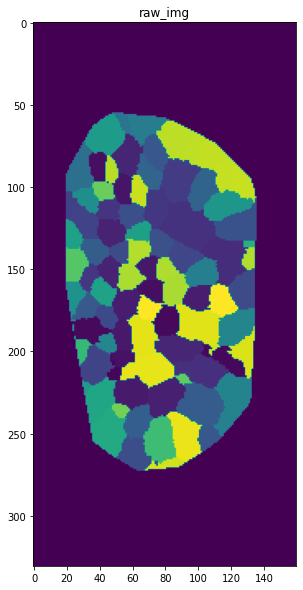

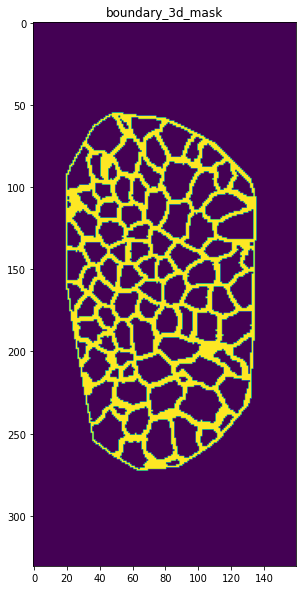

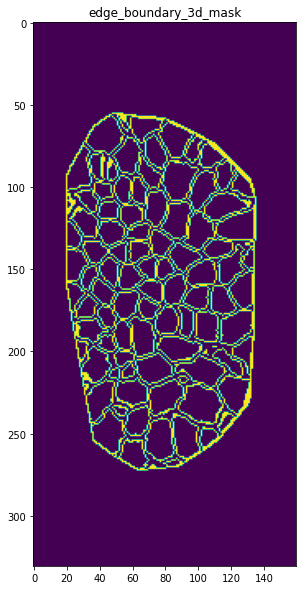

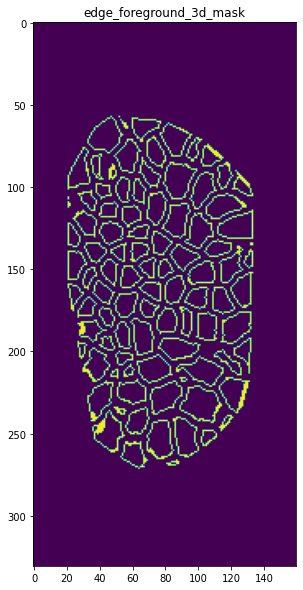

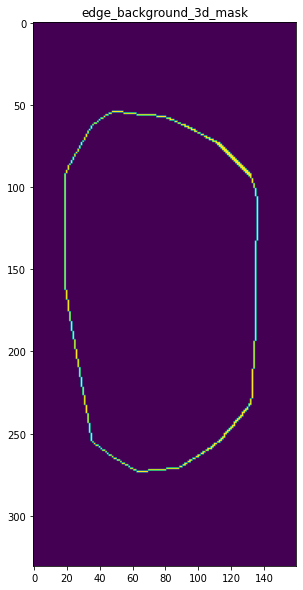

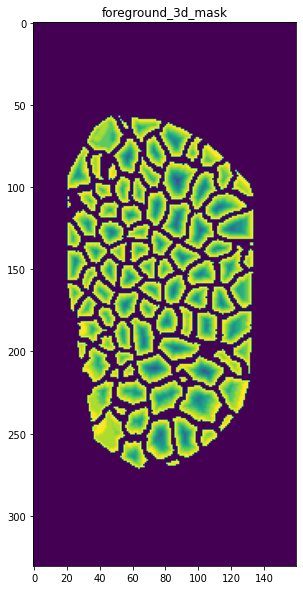

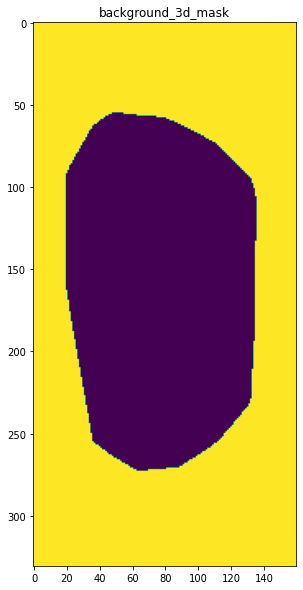

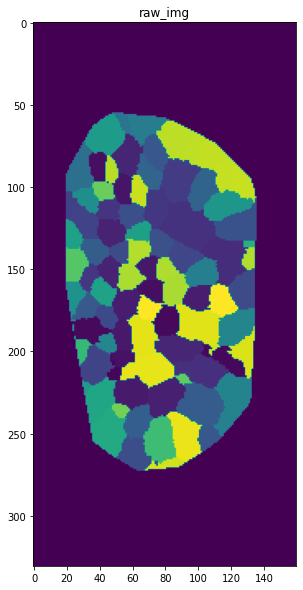

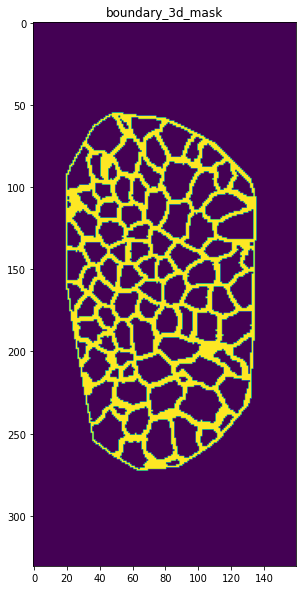

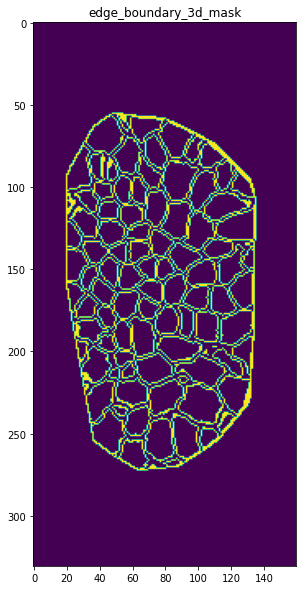

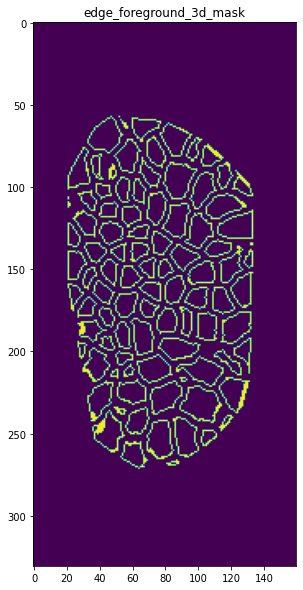

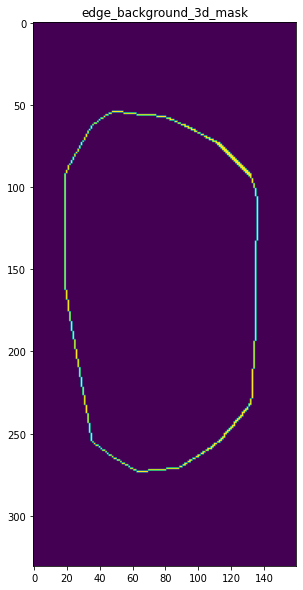

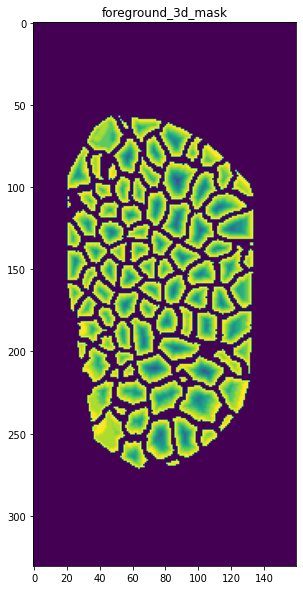

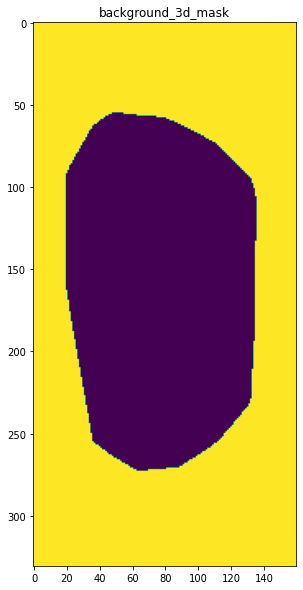

In [22]:
#N=150
N=139

plt.figure(figsize=(10,10))
plt.title("raw_img")
plt.imshow(img_3d[N,:,:])

plt.figure(figsize=(10,10))
plt.title("boundary_3d_mask")
plt.imshow(boundary_3d_mask[N,:,:])

plt.figure(figsize=(10,10))
plt.title("edge_boundary_3d_mask")
plt.imshow(edge_boundary_3d_mask[N,:,:])

plt.figure(figsize=(10,10))
plt.title("edge_foreground_3d_mask")
plt.imshow(edge_foreground_3d_mask[N,:,:])

plt.figure(figsize=(10,10))
plt.title("edge_background_3d_mask")
plt.imshow(edge_background_3d_mask[N,:,:])

plt.figure(figsize=(10, 10))
plt.title("foreground_3d_mask")
plt.imshow(foreground_3d_mask[N,:,:])

plt.figure(figsize=(10, 10))
plt.title("background_3d_mask")
plt.imshow(background_3d_mask[N,:,:])

In [7]:
edge_boundary_3d_mask.shape

(181, 331, 160)

In [8]:
import numpy as np
import scipy.ndimage as ndimage


test_array = np.array([[0,1,1,0],
                       [1,1,1,1],
                       [1,1,1,0],
                       [1,1,1,1]])

def test_func(values):
    print(f"values: {values}")
    if 0 in values:
        return 1
    else:
        return 0

footprint = np.array([[1,1,1],
                      [1,0,1],
                      [1,1,1]])

results = ndimage.generic_filter(test_array, test_func, footprint=footprint, mode='constant')


values: [0. 0. 0. 0. 1. 0. 1. 1.]
values: [0. 0. 0. 0. 1. 1. 1. 1.]
values: [0. 0. 0. 1. 0. 1. 1. 1.]
values: [0. 0. 0. 1. 0. 1. 1. 0.]
values: [0. 0. 1. 0. 1. 0. 1. 1.]
values: [0. 1. 1. 1. 1. 1. 1. 1.]
values: [1. 1. 0. 1. 1. 1. 1. 0.]
values: [1. 0. 0. 1. 0. 1. 0. 0.]
values: [0. 1. 1. 0. 1. 0. 1. 1.]
values: [1. 1. 1. 1. 1. 1. 1. 1.]
values: [1. 1. 1. 1. 0. 1. 1. 1.]
values: [1. 1. 0. 1. 0. 1. 1. 0.]
values: [0. 1. 1. 0. 1. 0. 0. 0.]
values: [1. 1. 1. 1. 1. 0. 0. 0.]
values: [1. 1. 0. 1. 1. 0. 0. 0.]
values: [1. 0. 0. 1. 0. 0. 0. 0.]


In [9]:
results

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1]])

In [10]:
# in 3d

import numpy as np
import scipy.ndimage as ndimage


test_array = np.array([[[0,1,1,0],
                        [1,1,1,1],
                        [1,1,1,0],
                        [1,1,1,1]],
                       [[0,1,1,0],
                        [1,1,1,1],
                        [1,1,1,0],
                        [1,1,1,1]],
                       [[0,1,1,0],
                        [1,1,1,1],
                        [1,1,1,0],
                        [1,1,1,1]]])

def test_func(values):
    print(f"values: {values}")
    if 0 in values:
        return 1
    else:
        return 0

footprint = np.array([[[1,1,1],
                       [1,0,1],
                       [1,1,1]],
                      [[1,1,1],
                       [1,0,1],
                       [1,1,1]],
                      [[1,1,1],
                       [1,0,1],
                       [1,1,1]]])

results = ndimage.generic_filter(test_array, test_func, footprint=footprint, mode='constant')


values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
values: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.]
values: [0. 0. 0

In [11]:
results


array([[[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]],

       [[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 1, 1]],

       [[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]])

In [12]:
input_3d_image=np.array(img_3d)
edge_boundary_3d_mask=np.zeros(input_3d_image.shape)

# edge boundary
edge_boundary_3d_mask_temp = copy.deepcopy(boundary_3d_mask)

def get_boundaries(values):
    if 0 in values:
        return 1
    else:
        return 0

footprint = np.array([[[1,1,1],
                       [1,0,1],
                       [1,1,1]],
                      [[1,1,1],
                       [1,0,1],
                       [1,1,1]],
                      [[1,1,1],
                       [1,0,1],
                       [1,1,1]]])
#temp_boundary_3d_mask[np.where(np.logical_and(temp_3d_img_dt>=1, temp_3d_img_dt<=k))]=1

edge_boundary_3d_mask_borders = ndimage.generic_filter(edge_boundary_3d_mask_temp, get_boundaries,
                                                       footprint=footprint,
                                                       mode='constant')

In [13]:
edge_boundary_3d_mask_borders
edge_boundary_3d_mask

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [14]:
# temp_boundary_3d_mask[np.where(np.logical_and(temp_3d_img_dt>=1, temp_3d_img_dt<=k))]=1
edge_boundary_3d_mask_new = edge_boundary_3d_mask[np.where(np.logical_and(boundary_3d_mask==1,
                                                           edge_boundary_3d_mask_borders==1))]

edge_boundary_3d_mask_new = edge_boundary_3d_mask[np.where(boundary_3d_mask==1)]

logical_shit = np.logical_and(boundary_3d_mask<1, edge_boundary_3d_mask_borders==1)

In [15]:
edge_boundary_3d_mask
edge_boundary_3d_mask_new

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
logical_shit.shape


(181, 331, 160)

In [17]:
test_arr = np.array([[0,1,1,0],
                       [0,1,0,1]])
np.where(test_arr<1)

(array([0, 0, 1, 1]), array([0, 3, 0, 2]))

loss save stuff

In [2]:
import pandas as pd

In [3]:
loss_df = pd.DataFrame({"epoch": [],
                        "loss": []})

In [4]:
loss_df

,epoch,loss


In [14]:
loss_df = pd.concat((loss_df, {"epoch": 2,
                          "loss": 3}), ignore_index=True)

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [11]:
loss_df.to_csv("output/asdf.csv")